In [6]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


In [7]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4393, done.
remote: Counting objects: 100% (1532/1532), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 4393 (delta 1457), reused 1399 (delta 1399), pack-reused 2861 (from 3)
Receiving objects: 100% (4393/4393), 649.93 MiB | 15.68 MiB/s, done.
Resolving deltas: 100% (2660/2660), done.
Updating files: 100% (248/248), done.


In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [9]:
image_path = download_data(
    source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
    destination="pizza_steak_sushi"
)
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

In [10]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [11]:
IMG_SIZE = 224

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [12]:
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d9971d47f90>,
 ['pizza', 'steak', 'sushi'])

In [13]:
image_batch, label_batch = next(iter(train_dataloader))
image, label = image_batch[0], label_batch[0]
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(-0.5, 223.5, 223.5, -0.5)

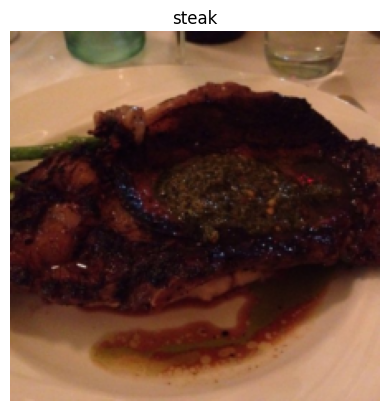

In [14]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [15]:
height = 224
width = 224
color_channels = 3
patch_size = 16

num_of_patches = int((height * width) / patch_size ** 2)
num_of_patches

196

In [16]:
embedding_layer_input_shape = (height, width, color_channels)
embedding_layer_output_shape = (num_of_patches, patch_size ** 2 * color_channels)
embedding_layer_input_shape, embedding_layer_output_shape

((224, 224, 3), (196, 768))

In [17]:
con2d = nn.Conv2d(
    in_channels=3,
    out_channels=768,
    kernel_size=patch_size,
    stride=patch_size,
    padding=0
)

torch.Size([1, 768, 14, 14])

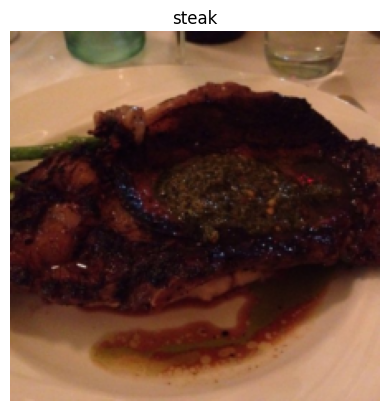

In [18]:
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

image_out_of_conv = con2d(image.unsqueeze(0))
image_out_of_conv.shape

In [19]:
flatten = nn.Flatten(start_dim=2, end_dim=3)
image_out_of_conv_flattened = flatten(image_out_of_conv)
image_out_of_conv_flattened.shape

torch.Size([1, 768, 196])

In [20]:
image_out_of_conv_flattend_reshaped = image_out_of_conv_flattened.permute(0, 2, 1)
image_out_of_conv_flattend_reshaped.shape

torch.Size([1, 196, 768])

In [21]:
class PatchEmbedding(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        patch_size: int = 16,
        embedding_dim: int = 768
    ):
      super().__init__()
      self.patcher = nn.Conv2d(
          in_channels=in_channels,
          out_channels=embedding_dim,
          kernel_size=patch_size,
          stride=patch_size,
          padding=0
      )
      self.flatten = nn.Flatten(start_dim=2, end_dim=3)
      self.patch_size = patch_size

    def forward(self, x):
      image_resolution = x.shape[-1]
      assert image_resolution % self.patch_size == 0, (
          f"Image size must be divisible by patch size, got image size: {image_resolution}, patch size: {self.patch_size}"
      )
      x = self.patcher(x)
      x = self.flatten(x)
      x = x.permute(0, 2, 1)
      return x

In [24]:
set_seeds()
patchify = PatchEmbedding(
    in_channels=3,
    patch_size=16,
    embedding_dim=768
)

patch_embedded_image = patchify(image.unsqueeze(0))
patch_embedded_image.shape

torch.Size([1, 196, 768])

In [25]:
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]

class_token = nn.Parameter(
    torch.randn(batch_size, 1, embedding_dim), requires_grad=True
)
class_token.shape

torch.Size([1, 1, 768])

In [26]:
patch_embedded_image_with_class = torch.cat((class_token, patch_embedded_image), dim=1)
patch_embedded_image_with_class.shape

torch.Size([1, 197, 768])

In [27]:
number_of_patches = int((height * width) / patch_size ** 2)
pos_embedding = nn.Parameter(
    torch.randn(1, number_of_patches + 1, embedding_dim), requires_grad=True
)
pos_embedding.shape

torch.Size([1, 197, 768])

In [28]:
patch_and_position_embedding = patch_embedded_image_with_class + pos_embedding
patch_and_position_embedding.shape

torch.Size([1, 197, 768])

In [29]:
class MultiheadSelfAttentionBlock(nn.Module):
    """LayerNorm 후 Multi-Head Self Attention(MSA)를 수행."""
    def __init__(
        self,
        embedding_dim: int = 768,
        num_heads: int = 12,
        attn_dropout: float = 0.0
    ):
        super().__init__()
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=num_heads,
            dropout=attn_dropout,
            batch_first=True
        )

    def forward(self, x):
        x_normed = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(
            query=x_normed,
            key=x_normed,
            value=x_normed,
            need_weights=False
        )
        return attn_output

In [30]:
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, num_heads=12)
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
patched_image_through_msa_block.shape

torch.Size([1, 197, 768])

In [36]:
class MLPBlock(nn.Module):
  def __init__(
      self,
      embedding_dim: int = 768,
      mlp_size: int = 3072,
      dropout: float = 0.1
  ):
    super().__init__()
    self.layer_norm = nn.LayerNorm(embedding_dim)
    self.mlp = nn.Sequential(
        nn.Linear(embedding_dim, mlp_size),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(mlp_size, embedding_dim),
        nn.Dropout(dropout)
    )

  def forward(self, x):
    x_normed = self.layer_norm(x)
    x_out = self.mlp(x_normed)
    return x_out

In [37]:
mip_block = MLPBlock(embedding_dim=768, mlp_size=3072, dropout=0.1)
patched_image_through_mlp_block = mip_block(patched_image_through_msa_block)
patched_image_through_mlp_block.shape

torch.Size([1, 197, 768])

In [38]:
class TransformerEncoderBlock(nn.Module):
    """MSA 블록 + residual, MLP 블록 + residual"""
    def __init__(
        self,
        embedding_dim: int = 768,
        num_heads: int = 12,
        mlp_size: int = 3072,
        mlp_dropout: float = 0.1,
        attn_dropout: float = 0.0
    ):
        super().__init__()
        self.msa_block = MultiheadSelfAttentionBlock(
            embedding_dim=embedding_dim,
            num_heads=num_heads,
            attn_dropout=attn_dropout
        )
        self.mlp_block = MLPBlock(
            embedding_dim=embedding_dim,
            mlp_size=mlp_size,
            dropout=mlp_dropout
        )

    def forward(self, x):
        x = self.msa_block(x) + x  # residual
        x = self.mlp_block(x) + x  # residual
        return x

In [39]:
transformer_encoder_block = TransformerEncoderBlock()
# summary(transformer_encoder_block, input_size=(1,197,768))  # 만약 torchinfo 요약을 보고 싶으면 주석 해제
x = transformer_encoder_block(patched_image_through_mlp_block)
x.shape

torch.Size([1, 197, 768])

In [40]:
class ViT(nn.Module):
    """ViT-Base 기본 아키텍처."""
    def __init__(
        self,
        img_size:int=224,
        in_channels:int=3,
        patch_size:int=16,
        num_transformer_layers:int=12,
        embedding_dim:int=768,
        mlp_size:int=3072,
        num_heads:int=12,
        attn_dropout:float=0.0,
        mlp_dropout:float=0.1,
        embedding_dropout:float=0.1,
        num_classes:int=1000
    ):
        super().__init__()

        assert img_size % patch_size == 0, (
            f"Image size must be divisible by patch size, got {img_size}, {patch_size}"
        )

        self.num_patches = (img_size*img_size) // (patch_size**2)

        self.class_embedding = nn.Parameter(
            torch.randn(1,1,embedding_dim), requires_grad=True
        )
        self.position_embedding = nn.Parameter(
            torch.randn(1,self.num_patches+1,embedding_dim), requires_grad=True
        )
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        self.patch_embedding = PatchEmbedding(
            in_channels=in_channels,
            patch_size=patch_size,
            embedding_dim=embedding_dim
        )

        self.transformer_encoder = nn.Sequential(
            *[
                TransformerEncoderBlock(
                    embedding_dim=embedding_dim,
                    num_heads=num_heads,
                    mlp_size=mlp_size,
                    mlp_dropout=mlp_dropout,
                    attn_dropout=attn_dropout
                ) for _ in range(num_transformer_layers)
            ]
        )

        self.classifier = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            nn.Linear(embedding_dim, num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]

        class_token = self.class_embedding.expand(batch_size, -1, -1)  # [batch, 1, embedding_dim]
        x = self.patch_embedding(x)                                   # [batch, num_patches, embedding_dim]
        x = torch.cat((class_token, x), dim=1)                        # prepend class token
        x = x + self.position_embedding                               # add position embedding
        x = self.embedding_dropout(x)

        x = self.transformer_encoder(x)                                # [batch, num_patches+1, embedding_dim]

        x = self.classifier(x[:,0])                                    # [batch, embedding_dim] -> [batch, num_classes]
        return x

In [41]:
vit = ViT(
    num_classes=len(class_names)
)
random_image_tensor = torch.randn(1,3,224,224)
vit(random_image_tensor).shape

torch.Size([1, 3])

In [42]:
from going_modular.going_modular import engine

set_seeds()
vit = ViT(num_classes=len(class_names)).to(device)

optimizer = torch.optim.Adam(
    vit.parameters(),
    lr=3e-3,
    betas=(0.9,0.999),
    weight_decay=0.3
)
loss_fn = nn.CrossEntropyLoss()

results = engine.train(
    model=vit,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=10,
    device=device
)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9635 | train_acc: 0.4414 | test_loss: 3.9618 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.4903 | train_acc: 0.2812 | test_loss: 1.8355 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.4819 | train_acc: 0.2891 | test_loss: 1.0237 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.2111 | train_acc: 0.2422 | test_loss: 1.0629 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.2227 | train_acc: 0.2969 | test_loss: 1.2710 | test_acc: 0.2604
Epoch: 6 | train_loss: 1.2413 | train_acc: 0.2422 | test_loss: 1.1083 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.1664 | train_acc: 0.3945 | test_loss: 1.2912 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1340 | train_acc: 0.2891 | test_loss: 1.1988 | test_acc: 0.1979
Epoch: 9 | train_loss: 1.1100 | train_acc: 0.4180 | test_loss: 1.0071 | test_acc: 0.5417
Epoch: 10 | train_loss: 1.2384 | train_acc: 0.2656 | test_loss: 1.1546 | test_acc: 0.2604
